# Metadata

In [15]:
import label_processor
import os
import random
import re
import pickle
import scipy
import torch
import tqdm
import transformers
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

from collections import defaultdict

from label_processor import list_series_values
from label_processor import LabelProcessorSimplified, list_series_value_counts

#from tqdm import trange
from tqdm.auto import tqdm, trange

In [16]:
raw_directory = "saved/"
pickle_directory = "saved/"
save_directory = "saved/"

### Raw conversation metadata

In [3]:
df = pd.read_pickle(save_directory+"raw_messages.pickle")

In [4]:
## number of messages, conversations
messages = df.shape[0]
conversations = df.CONVERSATION_ID.nunique()
print(f"There were {messages} messages from {conversations} conversations.")

There were 21394851 messages from 538075 conversations.


In [5]:
## timeframe
time_frame = pd.to_datetime(df.TIMESTAMP)
print(f"Conversations spanned from {time_frame.min()} to {time_frame.max()}. ")

Conversations spanned from 2018-02-12 23:44:48 to 2020-12-24 00:52:20. 


### Conversation length

In [6]:
df = pd.read_pickle(save_directory+'messages_without_weird_characters.pickle')
conversation_lengths = df[df.interaction!='bot'].groupby('conversation_id').message.agg(lambda x : sum(len(str(i)) for i in x))

In [7]:
## conversation length minimum, maximum, mean, median, IQR and standard deviation. 
minimum = conversation_lengths.min()
maximum = conversation_lengths.max()
mean = conversation_lengths.mean()
median = conversation_lengths.median()
iqr = conversation_lengths.quantile(0.75) - conversation_lengths.quantile(0.25)
std = conversation_lengths.std()

print(f"minimum: {minimum}")
print(f"maximum: {maximum}")
print(f"mean: {mean}")
print(f"median: {median}")
print(f"iqr: {iqr}")
print(f"std: {std}")

minimum: 1
maximum: 41750
mean: 2849.563309256237
median: 2563.0
iqr: 3535.0
std: 2365.2986557397844


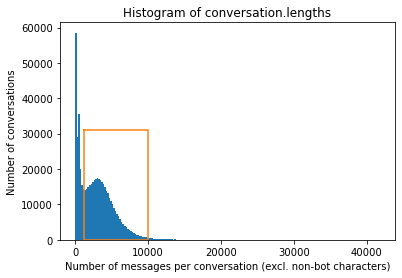

<Figure size 432x288 with 0 Axes>

In [8]:
## distribution of conversation lengths 
conversation_lengths.hist(bins=200)
plt.grid()
iqr = conversation_lengths.quantile(0.75) - conversation_lengths.quantile(0.25)
min_len = 1200
max_len = conversation_lengths.mean() + 2*iqr
y = 31000
plt.plot([min_len, min_len, max_len,max_len, min_len],[y,0,0,y,y])
plt.xlabel("Number of messages per conversation (excl. non-bot characters)")
plt.ylabel("Number of conversations")
plt.title("Histogram of conversation.lengths")
plt.show()
plt.savefig("figs/conversation_length_histogram_selected.pdf")

#### Consider whether the cut-off should be at the start of the 'third' modal distribution or at 1200 characters

<p> since the assumption is that less than 2200 characters may not be a conversation, check the number of responses by counselors and compare against 2200 characters and greater. Also consider using as cut-off the number of responses by counselors. 

In [9]:
## gets the conversation indexes of conversations with between 1200 and 2200 characters
between_1200_and_2200 = conversation_lengths[((conversation_lengths>=1200) & (conversation_lengths<=2200))].index
less_than_1200 = conversation_lengths[(conversation_lengths<1200)].index
more_than_2200 = conversation_lengths[(conversation_lengths>2200)].index

In [10]:
## gets the messages for these groups
messages_1200_and_2200 = df[((df.interaction!='bot') & (df.conversation_id.isin(between_1200_and_2200)))]
messages_less_than_1200 = df[((df.interaction!='bot') & (df.conversation_id.isin(less_than_1200)))]
messages_more_than_2200 = df[((df.interaction!='bot') & (df.conversation_id.isin(more_than_2200)))]

In [11]:
## groups the messages by conversation_id and gets the average number of counselor responses 
responses_1200_and_2200 = messages_1200_and_2200.groupby(['conversation_id', 'interaction']).size()
responses_less_than_1200 = messages_less_than_1200.groupby(['conversation_id', 'interaction']).size()
responses_more_than_2200 = messages_more_than_2200.groupby(['conversation_id', 'interaction']).size()

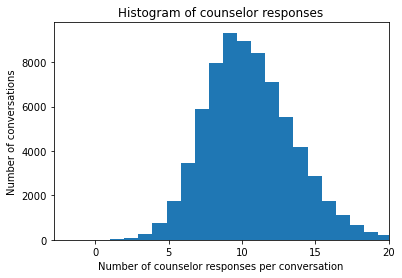

In [12]:
## distribution for between 1200 and 2200
counselor_1200_and_2200 = responses_1200_and_2200.drop(index='texter', level=1)
counselor_1200_and_2200.hist(bins=80)
plt.xlim(right=20)
plt.grid()
plt.xlabel("Number of counselor responses per conversation")
plt.ylabel("Number of conversations")
plt.title("Histogram of counselor responses")
plt.show()

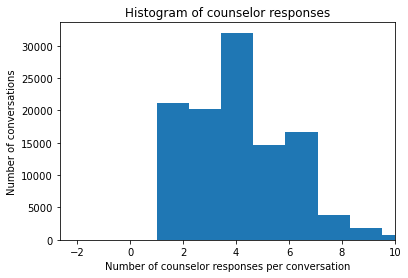

In [13]:
## distribution for less than 1200
counselor_less_than_1200 = responses_less_than_1200.drop(index='texter', level=1)
counselor_less_than_1200.hist(bins=60)
plt.xlim(right=10)
plt.grid()
plt.xlabel("Number of counselor responses per conversation")
plt.ylabel("Number of conversations")
plt.title("Histogram of counselor responses")
plt.show()

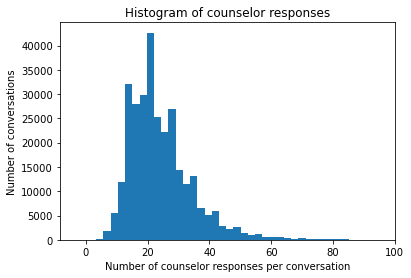

In [14]:
## distribution for more than 2200
counselor_more_than_2200 = responses_more_than_2200.drop(index='texter', level=1)
counselor_more_than_2200.hist(bins=80)
plt.grid()
plt.xlim(right=100)
plt.xlabel("Number of counselor responses per conversation")
plt.ylabel("Number of conversations")
plt.title("Histogram of counselor responses")
plt.show()

### Texter survey distribution

In [17]:
## texter survey response values
## change to df1 if doing the recurrent data analysis
df1 = pd.read_csv(raw_directory+"TEXTER_SURVEY_RESPONSE_VALUE.tsv", sep="\t")
df1.columns = df1.columns.str.lower()

In [18]:
## merge response metadata with response values on actor IDs
df2 = pd.read_csv(raw_directory+"TEXTER_SURVEY_RESPONSE.tsv", sep="\t")
df = df1.merge(df2, left_on='response_id', right_on='ID', how='inner')
df = df[['id', 'response_id', 'question_id', 'value', 'ACTOR_ID', 'TIME_SUBMITTED']]

In [17]:
## checking whether disparity in responses were due to tracking of texter IDs
## used daniel's timeframe to check

# df.loc[:, 'TIME_SUBMITTED'] = pd.to_datetime(df.TIME_SUBMITTED)

# daniel_date = pd.to_datetime('20200404', format='%Y%m%d')
# df = df[df.TIME_SUBMITTED < daniel_date]

# df.response_id.nunique()

# print(f"Earliest: {pd.to_datetime(df.TIME_SUBMITTED).min()}")
# print(f"Latest: {pd.to_datetime(df.TIME_SUBMITTED).max()}")

In [7]:
## load message dataset
df3 = pd.read_pickle(save_directory+'messages_without_weird_characters.pickle')

In [8]:
## get conversation IDs for recurrent data. Merge with response values on actor IDs
actor_and_convo = df3[df3.interaction=='texter'].groupby(['actor_id', 'conversation_id']).id.count()
actor_and_convo = actor_and_convo.reset_index()
actor_and_convo = actor_and_convo.drop(columns=['id'])

df = df.merge(actor_and_convo, left_on='ACTOR_ID', right_on='actor_id')

In [9]:
## age descriptives
age = df.loc[df.question_id == 69, :]
age.value = age.value.str.replace("13 or younger", "≤13")
age_desc = pd.DataFrame(age.value.value_counts())
age_desc.loc[:,'percentage'] = age_desc.value/age.shape[0]*100

age_desc

/data-imperial/lib/python3.9/site-packages/pandas/core/generic.py:5507: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,value,percentage
14-24,103482,58.507378
25-44,41198,23.292814
≤13,13663,7.724883
45-64,10051,5.682705
Prefer not to answer,8037,4.544015
65+,439,0.248205


In [162]:
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 12})

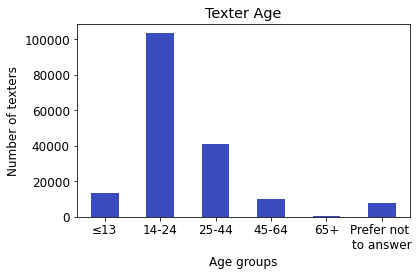

In [163]:
a_index = ['≤13', '14-24', '25-44', '45-64', '65+', 'Prefer not to answer']
ax = age_desc.loc[a_index, 'value'].plot.bar(cmap=plt.get_cmap("coolwarm"))
ax.grid(False)
a_index = ['≤13', '14-24', '25-44', '45-64', '65+', 'Prefer not \nto answer']
ax.set_xticklabels(a_index, rotation='horizontal')
ax.set_xlabel("Age groups")
ax.set_ylabel("Number of texters")
ax.set_title("Texter Age")
ax.figure.tight_layout()
ax.figure.savefig("figs/age.pdf")

In [12]:
## gender descriptives
gender = df.loc[df.question_id == 73, :]
gender.value = gender.value.str.lower()
gender.loc[gender.value.str.contains("non[\s-]?binary", regex=True), 'value'] = 'non-binary'
gender.loc[gender.value.str.contains("gender[\s-]?fluid", regex=True), 'value'] = 'gender-fluid'
gender_desc = pd.DataFrame(gender.value.value_counts())

others = gender_desc.value[gender_desc.index=='other - write in'][0]
others -= gender_desc.value[gender_desc.index=='non-binary'][0]
others -= gender_desc.value[gender_desc.index=='gender-fluid'][0]
gender_desc.value[gender_desc.index=='other - write in'] = others

total = gender.shape[0] - gender[gender.value == 'other - write in'].shape[0]
gender_desc.loc[:, 'percentage'] = gender_desc.value/total*100

gender_desc.loc[gender_desc.percentage>0.1, :]

/data-imperial/lib/python3.9/site-packages/pandas/core/generic.py:5507: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/data-imperial/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,value,percentage
female,140254,79.345791
male,22574,12.770772
prefer not to answer,4508,2.550307
trans male,3624,2.050203
other - write in,985,0.557243
genderqueer,1485,0.840108
non-binary,1318,0.745631
agender,919,0.519905
trans female,757,0.428257
gender-fluid,443,0.250618


In [141]:
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 20})

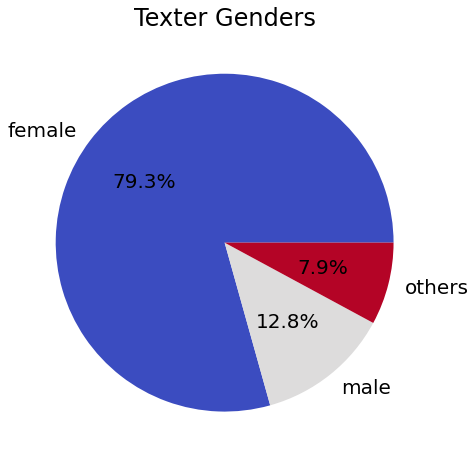

In [142]:
others = 0
for i in gender_desc.index:
    others += gender_desc.value.loc[i] if i not in ['female','male', 'other - write in'] else 0

plot_gender = gender_desc.loc[['female', 'male']]
plot_gender.loc['others'] = [others, others/total]

plt = plot_gender.plot.pie(y='value', 
                           figsize=(7,7), 
                           autopct='%1.1f%%', 
                           labels=['female', 'male', 'others'], 
                           legend=None, 
                           cmap=plt.get_cmap("coolwarm"))
plt.title.set_text("Texter Genders")
plt.get_yaxis().set_visible(False)
plt.figure.tight_layout()
plt.figure.savefig("figs/gender.pdf")

In [77]:
## sexual orientation descriptives
sex_orientation = df.loc[df.question_id == 74, :]
sex_orientation.loc[:, 'value'] = sex_orientation.value.str.lower()

replacements = {'heterosexual or straight':["str[a-z][ai]?[ght][ght]?[t]?", "heterosexual", "[a-z]ormal"], 
                'bisexual or pansexual':["bisexual", "pansexual"], 
                'asexual': ['asexual'], 
                'questioning or unsure':["unsure", "not sure", "i\sd[on't]?[ont]?\sk[now]?"]}

## calculates the number of values changed while making replacements
change = 0
for i in replacements: 
    before = sex_orientation[sex_orientation.value == i].shape[0]
    for r in replacements[i]: 
        sex_orientation.loc[sex_orientation.value.str.contains(r, regex=True),'value'] = i
    after = sex_orientation[sex_orientation.value == i].shape[0]
    change += (after - before)

/data-imperial/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/data-imperial/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [78]:
sex_desc = pd.DataFrame(sex_orientation.value.value_counts())

others = sex_desc.value[sex_desc.index == 'other - write in'][0]
others -= change
sex_desc.loc[sex_desc.index == 'other - write in', 'value'] = others

total = sex_desc.value.sum()
sex_desc['percentage'] = sex_desc.value/total*100
sex_desc = sex_desc.loc[sex_desc.percentage>0.5, :]
sex_desc

,value,percentage
heterosexual or straight,99759,56.653245
bisexual or pansexual,32071,18.213156
prefer not to answer,14291,8.115875
gay or lesbian,13443,7.634294
questioning or unsure,9048,5.138369
asexual,4732,2.687308
other - write in,1558,0.884790


In [166]:
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 15})

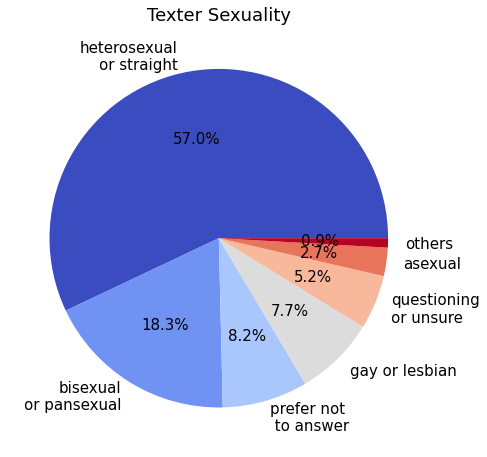

In [167]:
plt = sex_desc.plot.pie(y='value', 
                        figsize=(7,7), 
                        autopct='%1.1f%%', 
                        labels=["heterosexual\nor straight", 
                                "bisexual\nor pansexual", 
                                "prefer not\n to answer", 
                                "gay or lesbian", 
                                "questioning\nor unsure", 
                                "asexual", 
                                "others"], 
                        legend=None, 
                        cmap=plt.get_cmap("coolwarm"))
plt.title.set_text("Texter Sexuality")
plt.get_yaxis().set_visible(False)
plt.figure.tight_layout()
plt.figure.savefig("figs/sexuality.pdf")

In [82]:
## race descriptives
race = df[df.question_id == 75]
race.loc[:,'value'] = race.value.str.lower()
race_desc = pd.DataFrame(race.value.value_counts())

total = race.shape[0]
others = 0
for i in race_desc.value:
    if (i/total*100 < 3.0):
        others += i
race_desc.loc['others'] = [others]

race_desc['percentage'] = race_desc.value/race.shape[0]*100
race_desc = race_desc[race_desc.percentage>3.0]
race_desc

/data-imperial/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,value,percentage
white english / welsh / scottish / n. ireland / british,113137,79.214832
prefer not to answer,7415,5.191741
white - any other background,5478,3.835517
others,16793,11.757910


In [164]:
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 14})

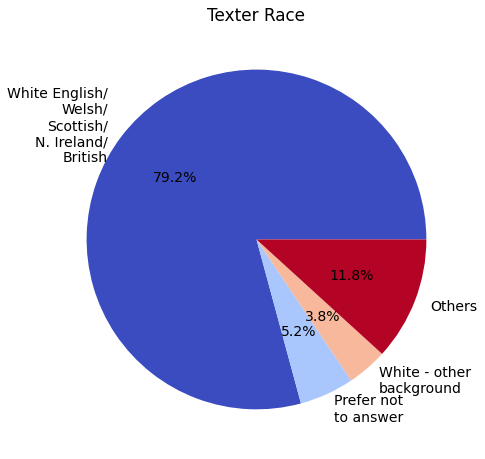

In [165]:
plt = race_desc.plot.pie(y='value', 
                         figsize=(7,7), 
                         autopct='%1.1f%%', 
                         labels=["White English/\nWelsh/\nScottish/\nN. Ireland/\nBritish", 
                                 "Prefer not \nto answer", 
                                 "White - other \nbackground", 
                                 "Others"], 
                         legend=None, 
                         cmap=plt.get_cmap("coolwarm"))
plt.title.set_text("Texter Race")
plt.get_yaxis().set_visible(False)
plt.figure.tight_layout()
plt.figure.savefig("figs/race.pdf")

### Texter Survey Responses

In [19]:
helpfulness = df.loc[df.question_id == 64, :]
how_helpful = df.loc[df.question_id == 65, :]

In [156]:
helpfulness_plot = helpfulness.value.value_counts()
helpfulness_plot = helpfulness_plot.append(how_helpful.value.value_counts())
helpfulness_plot = helpfulness_plot.rename({'No':'Not helpful','Yes': 'Helpful (no rating)'})

helpful = helpfulness_plot.loc['Helpful (no rating)']
helpful -= how_helpful.shape[0]

helpfulness_plot.loc['Helpful (no rating)'] = helpful
total = helpfulness.shape[0]
helpfulness_plot = helpfulness_plot.astype(float)
for i in helpfulness_plot.index:
    helpfulness_plot[i] = helpfulness_plot[i]/total*100
helpfulness_plot

Helpful (no rating)      0.943434
Not helpful             20.294783
5 (very helpful)        37.112857
4                       21.329302
3                       13.802397
2                        3.651934
1 (slightly helpful)     2.865294
Name: value, dtype: float64

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
h_index = ['Not helpful', 'Helpful (no rating)', '1 (slightly helpful)', '2', '3', '4', '5 (very helpful)']
ax = helpfulness_plot.loc[h_index].plot.bar(cmap=plt.get_cmap("coolwarm"))
ax.grid(False)
h_index = ['Not \nhelpful', 'Helpful \n(no rating)', '1 (slightly\n helpful)', '2', '3', '4', '5 (very \nhelpful)']
ax.set_xticklabels(h_index, rotation='horizontal')
ax.set_xlabel("Helpfulness rating")
ax.set_ylabel("Percentage of texters (%)")
ax.figure.tight_layout()
ax.figure.savefig("figs/helpfulness.pdf")

## Conversation Length for MultiLabel Dataset

In [2]:
df = pickle.load(open("saved/texts_with_multilabels.pickle", "rb"))

In [3]:
length = df.text.apply(lambda x: len(x.split()))

In [6]:
df.index.nunique()

54842

In [5]:
print(f"Mean: {length.mean()}")
print(f"Median: {length.median()}")
print(f"Minimum: {length.min()}")
print(f"Maximum: {length.max()}")

Mean: 919.8833558221801
Median: 873.0
Minimum: 180
Maximum: 2194


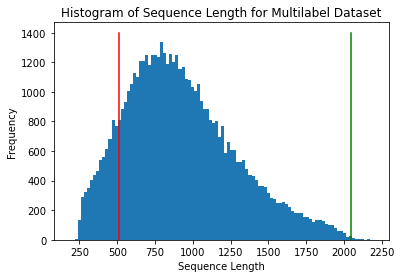

In [20]:
length.hist(bins=100)
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.title("Histogram of Sequence Length for Multilabel Dataset")
plt.plot([512, 512], [0, 1400], color='red')
plt.plot([2048, 2048], [0, 1400], color='green')
plt.grid(False)
plt.show()

## Topic Classes

In [3]:
df = pickle.load(open("saved/binarised_topics.pickle", "rb"))

In [56]:
df = pd.concat([df.dropna(), l_df[['18_anxiety', '18_depressed', '18_self_harm', '18_substance']].dropna()], axis=1, join='inner')

In [61]:
df.astype('float64').corr()

,substance,bully,other,gender,none,covid,physical_abuse,relationship,emotional_abuse,sexual_abuse,3rd_party,isolated,prank,testing,eating,bereavement,18_anxiety,18_depressed,18_self_harm,18_substance
substance,1.000000,-0.004872,-0.025918,-0.004689,-0.030785,-0.009439,-0.003262,-0.014998,-0.004778,-0.006821,-0.011213,-0.022627,-0.004255,-0.007253,-0.008391,-0.008906,-0.020127,-0.006485,-0.021505,1.000000
bully,-0.004872,1.000000,-0.020984,-0.003796,-0.024924,-0.007642,-0.002641,-0.006401,-0.003868,-0.005522,-0.009078,-0.018319,-0.003445,-0.005872,-0.006794,-0.007210,0.011816,-0.030467,-0.017411,-0.004872
other,-0.025918,-0.020984,1.000000,-0.020194,-0.107378,-0.028502,-0.014051,-0.063978,-0.020576,-0.029377,-0.048294,-0.054287,-0.018327,-0.031236,-0.036140,-0.038356,-0.020958,-0.084280,-0.058868,-0.025918
gender,-0.004689,-0.003796,-0.020194,1.000000,-0.023986,-0.007354,-0.002542,0.020083,-0.003722,-0.005314,-0.008737,-0.017629,-0.003315,-0.005651,-0.006538,-0.006939,-0.029101,-0.029320,-0.016755,-0.004689
none,-0.030785,-0.024924,-0.107378,-0.023986,1.000000,-0.048286,-0.016689,-0.148966,-0.024440,-0.034893,-0.057362,-0.111040,-0.021768,-0.037101,-0.042926,-0.045558,-0.172513,-0.172315,-0.098494,-0.030785
covid,-0.009439,-0.007642,-0.028502,-0.007354,-0.048286,1.000000,-0.005117,-0.025762,-0.007494,-0.010699,-0.017588,0.011540,-0.006674,-0.011376,-0.013162,-0.013969,0.094973,-0.030872,-0.033731,-0.009439
physical_abuse,-0.003262,-0.002641,-0.014051,-0.002542,-0.016689,-0.005117,1.000000,0.038889,-0.002590,-0.003698,-0.006079,-0.012266,-0.002307,-0.003932,-0.004549,-0.004828,-0.020248,-0.020401,-0.011658,-0.003262
relationship,-0.014998,-0.006401,-0.063978,0.020083,-0.148966,-0.025762,0.038889,1.000000,0.082686,-0.002542,-0.059205,0.153732,-0.022467,-0.038293,-0.031890,-0.014167,0.059920,0.089938,-0.054165,-0.014998
emotional_abuse,-0.004778,-0.003868,-0.020576,-0.003722,-0.024440,-0.007494,-0.002590,0.082686,1.000000,-0.005415,-0.008902,-0.017963,-0.003378,-0.005758,-0.006662,-0.007070,-0.029652,-0.029876,-0.017073,-0.004778
sexual_abuse,-0.006821,-0.005522,-0.029377,-0.005314,-0.034893,-0.010699,-0.003698,-0.002542,-0.005415,1.000000,-0.012710,-0.025646,-0.004823,-0.008220,-0.009511,-0.010094,-0.018166,-0.026693,-0.024375,-0.006821


In [45]:
total = df.shape[0]

for i in df.columns:
    print(f"Percentage negative for {i}: {df[i].value_counts()[0] / total}")
    print(f"Class imbalance for {i}: {df[i].value_counts()[0] / df[i].value_counts()[1]} \n")

Percentage negative for substance: 0.9532850931865859
Class imbalance for substance: 166.1715799933753 

Percentage negative for bully: 0.955253716822231
Class imbalance for bully: 253.50882501260716 

Percentage negative for other: 0.862718904867593
Class imbalance for other: 8.958385951065509 

Percentage negative for gender: 0.9555311483384512
Class imbalance for gender: 273.7365269461078 

Percentage negative for none: 0.8285416223282965
Class imbalance for none: 6.349940290682434 

Percentage negative for covid: 0.9450305554711015
Class imbalance for covid: 67.54420752410702 

Percentage negative for physical_abuse: 0.9573287525462892
Class imbalance for physical_abuse: 565.4320987654321 

Percentage negative for relationship: 0.8212447934085312
Class imbalance for relationship: 5.960679116211073 

Percentage negative for emotional_abuse: 0.9553981332279347
Class imbalance for emotional_abuse: 263.651809124279 

Percentage negative for sexual_abuse: 0.9516642090541485
Class imbala

In [34]:
l_df = torch.load("saved/labelizer.torch")
l_df = l_df.df

In [52]:
[i for i in df.columns if '18_[' in i and ',' not in i]

['18_[substance]',
 '18_[bully]',
 '18_[other]',
 '18_[gender]',
 '18_[none]',
 '18_[covid_19]',
 '18_[self_harm]',
 '18_[abuse_physical]',
 '18_[relationship]',
 '18_[abuse_emotional]',
 '18_[depressed]',
 '18_[abuse_sexual]',
 '18_[3rd_party]',
 '18_[isolated]',
 '18_[suicide]',
 '18_[anxiety]',
 '18_[prank]',
 '18_[testing]',
 '18_[eating]',
 '18_[bereavement]']

In [48]:
labels = ['19_desire_x', '19_intent_x', '19_capability_x', '19_timeframe_x', 
          '18_anxiety', '18_depressed', '18_self_harm', '18_substance', '64_Yes']

for i in labels:
    print(f"Percentage negative for {i}: {df[i].value_counts()[0] / total}")
    print(f"Class imbalance for {i}: {df[i].value_counts()[0] / df[i].value_counts()[1]} \n")

Percentage negative for 19_desire_x: 0.7505054574199629
Class imbalance for 19_desire_x: 3.008103703026703 

Percentage negative for 19_intent_x: 0.8596063512815055
Class imbalance for 19_intent_x: 6.1228293382780885 

Percentage negative for 19_capability_x: 0.8990833358669544
Class imbalance for 19_capability_x: 8.909166227310386 

Percentage negative for 19_timeframe_x: 0.9454391018819738
Class imbalance for 19_timeframe_x: 17.328144046250827 

Percentage negative for 18_anxiety: 0.7785412422851236
Class imbalance for 18_anxiety: 4.3137114520051805 

Percentage negative for 18_depressed: 0.8173113465689702
Class imbalance for 18_depressed: 4.473793698838165 

Percentage negative for 18_self_harm: 0.9315599252075035
Class imbalance for 18_self_harm: 13.611322431074216 

Percentage negative for 18_substance: 0.9942632483050075
Class imbalance for 18_substance: 173.3146737330242 

Percentage negative for 64_Yes: 0.017592198473746618
Class imbalance for 64_Yes: 0.17238618378177079 



## Interactions between labels

In [24]:
df = torch.load("saved/labelizer.torch")
df = df.df

In [7]:
labels = ['19_desire_x', '19_intent_x', '19_capability_x', '19_timeframe_x', 
          '18_anxiety', '18_depressed', '18_self_harm', '18_substance', '64_Yes']
corr = df[labels].corr()

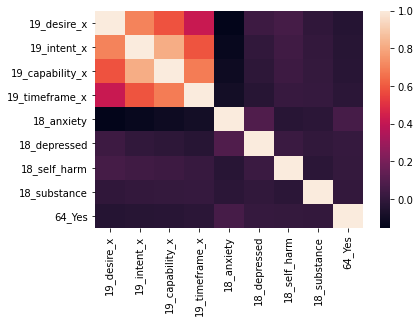

In [9]:
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)
plt.show()

In [16]:
corr

,19_desire_x,19_intent_x,19_capability_x,19_timeframe_x,18_anxiety,18_depressed,18_self_harm,18_substance,64_Yes
19_desire_x,1.000000,0.700923,0.581069,0.416649,-0.153693,0.035415,0.055947,-0.007165,-0.036992
19_intent_x,0.700923,1.000000,0.814133,0.587975,-0.127704,-0.002570,0.040519,0.000156,-0.035104
19_capability_x,0.581069,0.814133,1.000000,0.680264,-0.112513,-0.014827,0.033236,0.004288,-0.029428
19_timeframe_x,0.416649,0.587975,0.680264,1.000000,-0.090856,-0.032143,0.013913,0.008893,-0.022883
18_anxiety,-0.153693,-0.127704,-0.112513,-0.090856,1.000000,0.085239,-0.027591,-0.020127,0.062219
18_depressed,0.035415,-0.002570,-0.014827,-0.032143,0.085239,1.000000,0.023529,-0.004918,0.010595
18_self_harm,0.055947,0.040519,0.033236,0.013913,-0.027591,0.023529,1.000000,-0.020589,0.004713
18_substance,-0.007165,0.000156,0.004288,0.008893,-0.020127,-0.004918,-0.020589,1.000000,0.000769
64_Yes,-0.036992,-0.035104,-0.029428,-0.022883,0.062219,0.010595,0.004713,0.000769,1.000000


In [15]:
for i in ['19_desire_x', '19_intent_x', '19_capability_x', '19_timeframe_x', 
          '18_depressed', '64_Yes']:
    corr_df = df[['18_anxiety', i]].dropna()
    print(f"anxiety x {i}: {scipy.stats.pearsonr(corr_df['18_anxiety'], corr_df[i])}")

anxiety x 19_desire_x: (-0.1536929029942683, 0.0)
anxiety x 19_intent_x: (-0.12770350419829815, 0.0)
anxiety x 19_capability_x: (-0.11251333151047291, 0.0)
anxiety x 19_timeframe_x: (-0.0908556268742586, 0.0)
anxiety x 18_depressed: (0.08523864996061012, 0.0)
anxiety x 64_Yes: (0.062218860569253076, 1.4368138914187388e-54)


In [17]:
corr_df = df[['18_self_harm', '19_desire_x']].dropna()
print(f"self harm x suicidal desire: {scipy.stats.pearsonr(corr_df['18_self_harm'], corr_df['19_desire_x'])}")

self harm x suicidal desire: (0.055947391750074696, 0.0)


### Additional Tests 

In [26]:
labels = pickle.load(open("saved/multilabel_text_with_preds.pickle", "rb"))
helpful = labels.helpful

In [11]:
basic_features = pickle.load(open("saved/basic_features.pickle", "rb"))
basic_features.head()

,total_time_seconds,texter_message_char_len,texter_message_word_len,counselor_message_char_len,counselor_message_word_len,num_messages_bot,num_messages_counselor,num_messages_texter,texter_avg_word_len,counselor_avg_word_len,texter_avg_words_per_message,counselor_avg_words_per_message,avg_time_per_message_seconds
conversation_id,,,,,,,,,,,,,
00002d3c35ea7519b18b6861cfe41ec59fbfce2c3939b067b06aec288be2c8fd,3798,848,151,2204.0,394.0,5.0,19.0,17.0,5.615894,5.593909,8.882353,20.736842,105.500000
000076961451e5ad70f96d38761481a1f234c1257096a7be6074c628d424e33b,2545,658,120,1736.0,307.0,8.0,16.0,18.0,5.483333,5.654723,6.666667,19.187500,74.852941
000087ec0f14337a6124ed7aa770cee1e29fcc9be90ff4c9444544c3b1d2ca48,4839,1910,340,1742.0,320.0,7.0,18.0,20.0,5.617647,5.443750,17.000000,17.777778,127.342105
0000f828b4f5d81aae7188d121046398fd4815210b5f9acac029d9651a5ef529,2322,1163,202,1647.0,309.0,8.0,17.0,17.0,5.757426,5.330097,11.882353,18.176471,68.294118
0001008bc9470855694eebbf9842ba9893a9d3d02b16908515ad418bb3b2c256,2032,1046,182,1078.0,197.0,7.0,12.0,12.0,5.747253,5.472081,15.166667,16.416667,84.666667


In [29]:
helpful_length = pd.concat([helpful.dropna(), basic_features], 
                           axis=1, 
                           join='inner')

In [30]:
helpful_length.corr()

,helpful,total_time_seconds,texter_message_char_len,texter_message_word_len,counselor_message_char_len,counselor_message_word_len,num_messages_bot,num_messages_counselor,num_messages_texter,texter_avg_word_len,counselor_avg_word_len,texter_avg_words_per_message,counselor_avg_words_per_message,avg_time_per_message_seconds
helpful,1.000000,-0.014383,0.138855,0.139241,0.109137,0.102769,-0.044530,0.101385,0.052446,-0.002835,0.110603,0.089562,-0.001547,-0.117681
total_time_seconds,-0.014383,1.000000,0.312484,0.314439,0.498489,0.503355,0.401140,0.482579,0.300504,-0.018818,0.012515,0.029335,0.022532,0.513495
texter_message_char_len,0.138855,0.312484,1.000000,0.997330,0.435553,0.432800,0.009237,0.410438,0.528122,0.073877,0.104345,0.525572,0.042591,-0.165657
texter_message_word_len,0.139241,0.314439,0.997330,1.000000,0.442297,0.440381,0.009297,0.418069,0.539767,0.011994,0.095375,0.518090,0.041963,-0.172349
counselor_message_char_len,0.109137,0.498489,0.435553,0.442297,1.000000,0.996921,-0.048228,0.944080,0.567202,-0.085995,0.171281,-0.100109,0.087426,-0.279540
counselor_message_word_len,0.102769,0.503355,0.432800,0.440381,0.996921,1.000000,-0.045116,0.945649,0.574282,-0.097592,0.099973,-0.107159,0.092766,-0.278217
num_messages_bot,-0.044530,0.401140,0.009237,0.009297,-0.048228,-0.045116,1.000000,-0.039915,0.033713,0.001325,-0.054394,-0.014448,-0.017753,0.412283
num_messages_counselor,0.101385,0.482579,0.410438,0.418069,0.944080,0.945649,-0.039915,1.000000,0.603919,-0.100464,0.111287,-0.152557,-0.205679,-0.323180
num_messages_texter,0.052446,0.300504,0.528122,0.539767,0.567202,0.574282,0.033713,0.603919,1.000000,-0.131914,0.007146,-0.301068,-0.110030,-0.430318
texter_avg_word_len,-0.002835,-0.018818,0.073877,0.011994,-0.085995,-0.097592,0.001325,-0.100464,-0.131914,1.000000,0.137894,0.131829,0.017211,0.109082


## Bot Messages and Conversations About Suicide

In [2]:
l_df = torch.load("saved/labelizer.torch")
l_df = l_df.df

In [3]:
df = pickle.load(open("saved/selected_messages.pickle", "rb"))

In [4]:
index = set(l_df.index) & set(df.conversation_id)

In [7]:
l_df = l_df.loc[index, ['18_suicide']]

In [8]:
bot_messages = df[df.interaction == 'bot'].groupby('conversation_id').count().loc[:, 'interaction']

In [9]:
l_df = pd.concat([l_df, bot_messages], axis=1, join='outer')

In [10]:
l_df.loc[l_df.interaction.isna(), 'interaction'] = 0

In [11]:
l_df = l_df.dropna()
l_df.shape

(363145, 2)

In [46]:
for i in l_df.columns[:-1]:
    print(f"{i}: {scipy.stats.ttest_ind(l_df.loc[l_df[i] == 1.0, 'interaction'], l_df.loc[l_df[i] == 0.0, 'interaction'], alternative='less')}")
    print(f"{scipy.stats.pearsonr(l_df[i], l_df.interaction)}")
    print("\n")

19_desire_x: Ttest_indResult(statistic=-79.40895794820162, pvalue=0.0)
(-0.1306448748168438, 0.0)


19_intent_x: Ttest_indResult(statistic=-94.26866312898508, pvalue=0.0)
(-0.15455341716323096, 0.0)


19_capability_x: Ttest_indResult(statistic=-105.68145284822087, pvalue=0.0)
(-0.17273571806038104, 0.0)


19_timeframe_x: Ttest_indResult(statistic=-130.7501075693166, pvalue=0.0)
(-0.21203812687684856, 0.0)




In [12]:
i = '18_suicide'
print(f"{i}: {scipy.stats.ttest_ind(l_df.loc[l_df[i] == 1.0, 'interaction'], l_df.loc[l_df[i] == 0.0, 'interaction'], alternative='less')}")
print(f"{scipy.stats.pearsonr(l_df[i], l_df.interaction)}")

18_suicide: Ttest_indResult(statistic=-73.53774118005245, pvalue=0.0)
(-0.12113275840724086, 0.0)


In [14]:
l_df.shape

(363145, 2)